# 목차  
1. 전처리  
    [1-1. 결측치](#결측치-확인)  
    [1-2. 서브카테고리 분류](#서브-카테고리-분류)  
    [1-3. 판매자 지역 변수 세분화](#판매자-지역-변수-세분화)  
2. EDA  
    [2-1. 숙박 인원수](#숙박-인원-수)  
    [2-2. 배송비](#배송비)  
    [2-3. 서브카테고리](#서브-카테고리)  
    [2-4. 마감 기한](#마감-기한)  
    [2-5. 시장 가격](#시장-가격)  
    [2-6. 옵션](#옵션)  
    [2-7. 체크인,아웃 시간](#체크인아웃-시간)  
    [2-8. 숙소 종류](#숙소-종류)  
    [2-9. 국내/외국](#국내외국)  

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

In [3]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [4]:
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'data')
data_file_path = os.path.join(data_directory, 'description_complete2.csv')
df = pd.read_csv(data_file_path,index_col=0)

In [5]:
df.columns

Index(['platform', 'original_link', 'post_time', 'title', 'view_count',
       'like_count', 'price', 'images', 'description', 'category', 'status',
       'seller_location', 'city_goo', 'citydong', 'description_1',
       'expiration_stdate', 'expiration_endate', 'room_type', 'head_count',
       'shipping_fee', 'transaction_method', 'market_price', 'options',
       'parking', 'check_in_time', 'check_out_time', 'stay_type', 'foreignn',
       'event', 'advertise'],
      dtype='object')

## 전처리

In [6]:
df['foreignn'] = df['foreignn'].apply(lambda x: '국내' if x in ['Domestic', 'domestic'] else x)

In [7]:
df['stay_type'] = df['stay_type'].apply(lambda x: '호텔' if x in ['Hotel', '해외 호텔','hotel','해외'] else x)

In [8]:
df['stay_type'].value_counts()

stay_type
호텔     1580
리조트     189
기타      119
풀빌라       9
모텔        9
펜션        5
Name: count, dtype: int64

In [9]:
df['foreignn'].value_counts()

foreignn
국내    1728
외국     183
Name: count, dtype: int64

### 결측치 확인

<Axes: >

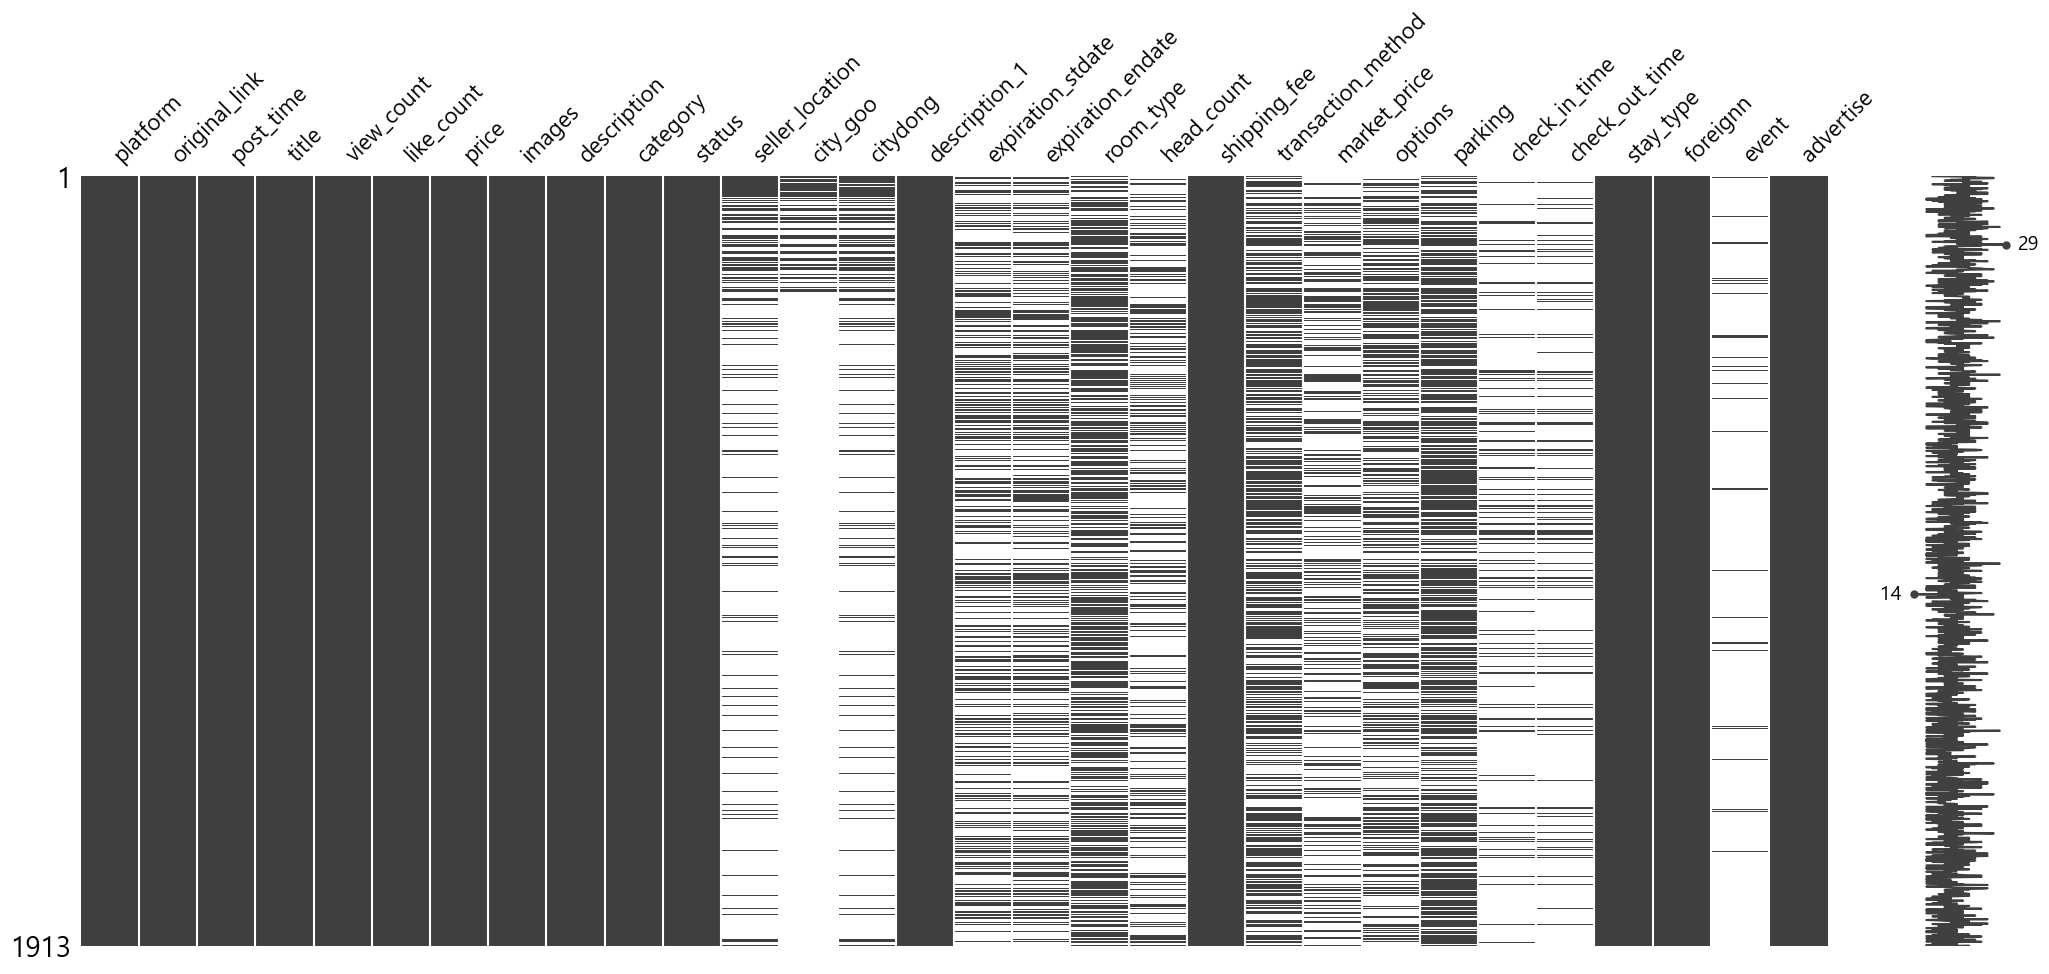

In [10]:
msno.matrix(df)

In [11]:
df.dropna(subset=['shipping_fee'],inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
df['foreignn'] = df['foreignn'].fillna("국내")
df['stay_type'] = df['stay_type'].fillna("호텔")

In [13]:
df.isnull().sum()

platform                 0
original_link            0
post_time                0
title                    0
view_count               0
like_count               0
price                    0
images                   0
description              0
category                 0
status                   0
seller_location       1558
city_goo              1776
citydong              1571
description_1            0
expiration_stdate     1227
expiration_endate     1186
room_type              684
head_count            1337
shipping_fee             0
transaction_method     784
market_price          1373
options               1026
parking                636
check_in_time         1650
check_out_time        1650
stay_type                0
foreignn                 0
event                 1827
advertise                0
dtype: int64

### 서브 카테고리 분류

In [14]:
df['sub_category'] = df['stay_type']

In [15]:
df.loc[df['foreignn'] == '외국', 'sub_category'] = '해외 숙소'

In [16]:
df[(df['foreignn']=="국내")&(df['stay_type']=='호텔')]['price'].mean()

271414.8302816901

In [17]:
df['sub_category'].value_counts()

sub_category
호텔       1420
리조트       184
해외 숙소     183
기타        102
풀빌라         9
모텔          9
펜션          5
Name: count, dtype: int64

In [18]:
df.loc[(df['foreignn'] == '국내') & (df['stay_type'] == '호텔'), 'sub_category'] = df.loc[
    (df['foreignn'] == '국내') & (df['stay_type'] == '호텔'), 'price'
].apply(lambda x: '가격대 높은 호텔' if x > 300000 else '가격대 낮은 호텔')


In [19]:
df['sub_category'].value_counts()

sub_category
가격대 낮은 호텔    945
가격대 높은 호텔    475
리조트          184
해외 숙소        183
기타           102
풀빌라            9
모텔             9
펜션             5
Name: count, dtype: int64

In [20]:
df.loc[df['event'].notnull(), 'sub_category'] = "이벤트 관련 숙소"

In [21]:
df['sub_category'].value_counts()

sub_category
가격대 낮은 호텔    901
가격대 높은 호텔    441
리조트          182
해외 숙소        181
기타           100
이벤트 관련 숙소     85
풀빌라            9
모텔             8
펜션             5
Name: count, dtype: int64

### 판매자 지역 변수 세분화

In [22]:
df['city'] = None
df['city_goo'] = None
df['city_dong'] = None

def split_location(location):
    if pd.isna(location):
        return pd.Series([None, None, None])

    # 공백 제거
    location_parts = location.strip().split(" ")
    
    si = None
    goo = None
    dong = None
    
    for part in location_parts:
        clean_part = part.strip()
        if clean_part.endswith('시'):
            si = clean_part
        elif clean_part.endswith('구'):
            goo = clean_part
        elif clean_part.endswith('동'):
            dong = clean_part
    
    return pd.Series([si, goo, dong])

# city_dong으로 컬럼명 수정
df[['city', 'city_goo', 'city_dong']] = df['seller_location'].apply(split_location)


In [23]:
seoul_goo = ["강남구", "강동구", "강북구", "강서구", "관악구", "광진구", "구로구", "금천구", "노원구", "도봉구", "동대문구", "동작구", "마포구", "서대문구", "서초구", "성동구", "성북구", "송파구", "양천구", "영등포구", "용산구", "은평구", "종로구", "중구", "중랑구"]

In [24]:
df.loc[df['city_goo'].isin(seoul_goo) & df['city'].isna(), 'city'] = '서울특별시'

In [25]:
df[['seller_location','city', 'city_goo', 'city_dong']].head(30)

,seller_location,city,city_goo,city_dong
0,담양군 금성면,None,None,None
1,연제구 연산제2동,None,연제구,연산제2동
2,광진구 구의제3동,서울특별시,광진구,구의제3동
3,영등포구 여의동,서울특별시,영등포구,여의동
4,수성구 지산동,None,수성구,지산동
5,전주시 덕진구 인후3동,전주시,덕진구,인후3동
6,서귀포시 동홍동,서귀포시,None,동홍동
7,송파구 삼전동,서울특별시,송파구,삼전동
8,강남구 삼성동,서울특별시,강남구,삼성동
9,용산구 이태원제1동,서울특별시,용산구,이태원제1동


## EDA

### 숙박 인원 수

In [26]:
df['head_count'].describe()

count      575.000000
mean       159.233043
std       2651.482765
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max      45000.000000
Name: head_count, dtype: float64

In [27]:
df[df['head_count']>=10]['head_count']

151       10.0
384    45000.0
624    45000.0
700       28.0
953       30.0
Name: head_count, dtype: float64

In [28]:
df.loc[df["head_count"]==45000,'head_count'] = np.nan

In [29]:
df['head_count'].describe()

count    573.000000
mean       2.720768
std        1.918498
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       30.000000
Name: head_count, dtype: float64

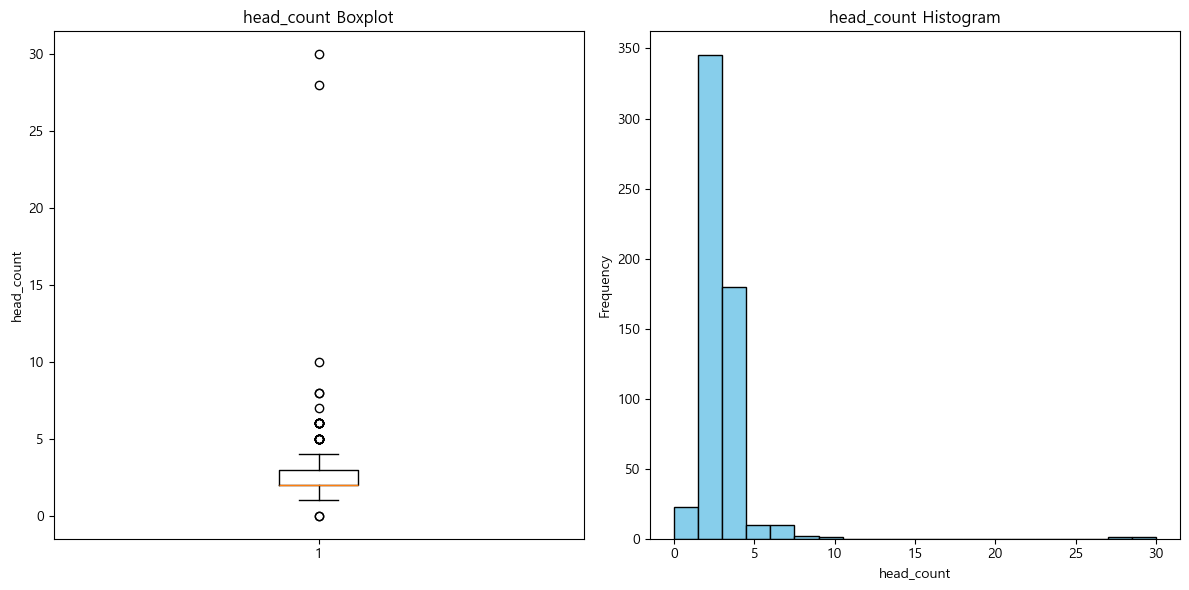

In [30]:
# head_count에 대한 박스플롯 및 히스토 그램
head_df = df[df['head_count'].notnull()]
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

axes[0].boxplot(head_df['head_count'])
axes[0].set_title('head_count Boxplot')
axes[0].set_ylabel('head_count')

axes[1].hist(head_df['head_count'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('head_count Histogram')
axes[1].set_xlabel('head_count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [31]:
head_df[['head_count','price']].corr()

,head_count,price
head_count,1.000000,-0.009113
price,-0.009113,1.000000


In [32]:
head_df[head_df['sub_category']=='가격대 높은 호텔'][['head_count','price']].corr()

,head_count,price
head_count,1.000000,0.005151
price,0.005151,1.000000


In [33]:
head_df[head_df['sub_category']=='가격대 낮은 호텔'][['head_count','price']].corr()

,head_count,price
head_count,1.000000,0.107427
price,0.107427,1.000000


In [34]:
head_df[head_df['sub_category']=='해외 숙소'][['head_count','price']].corr()

,head_count,price
head_count,1.000000,0.245278
price,0.245278,1.000000


### 배송비

In [35]:
df['shipping_fee'].describe()

count     1912.000000
mean        10.198745
std        261.872583
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      10000.000000
Name: shipping_fee, dtype: float64

In [36]:
df[df['shipping_fee']>0]

,platform,original_link,post_time,title,view_count,like_count,price,images,description,category,...,parking,check_in_time,check_out_time,stay_type,foreignn,event,advertise,sub_category,city,city_dong
148,번개장터,https://bunjang.co.kr/products/285963787,2024-09-29 10:55:21.985,경주힐튼호텔 숙박권,152,4,310000,https://media.bunjang.co.kr/product/285963787_...,경주 힐튼호텔 숙박권 판매합니다\n\n​\n\n일반택배 +4000\n반값택배 +20...,여행/숙박/렌트,...,NaN,NaN,NaN,호텔,국내,NaN,False,가격대 높은 호텔,경주시,황성동
263,번개장터,https://bunjang.co.kr/products/282114657,2024-09-26 10:55:21.986,부산 사상 MU 호텔(감전점) 금요일 숙박,399,2,40000,https://media.bunjang.co.kr/product/282114657_...,"부산 사상 MU 금요일 숙박 판매합니다\n정가 65,000, 쿠폰 적용시 55,00...",여행/숙박/렌트,...,False,NaN,NaN,호텔,국내,NaN,False,가격대 낮은 호텔,None,None
296,중고나라,https://web.joongna.com/product/188519886,2024-10-10 11:31:55.934,서울 웨스틴 조선호텔 아리아 식사권 1인 =>16.5만원,4,0,165000,https://img2.joongna.com/cafe-article-data/liv...,"일요일 연락X, (월~토)까지 미리 구매하세요~ 웨스틴 조선호텔 아리아 1인 =>1...",여행/숙박이용권,...,False,오전,오후 6시 30분,호텔,국내,NaN,False,가격대 낮은 호텔,None,None
1305,중고나라,https://web.joongna.com/product/181962684,2024-10-10 11:31:55.978,"신라호텔 더 파크뷰 ,팔선,아리아께 최대 33%할인 S멤버쉽 대여합니다",44,1,10000,https://img2.joongna.com/cafe-article-data/liv...,사용료는 없고 왕복 등기우편 10000원 + 보증금 20000원 보증금은 결제후 포...,여행/숙박이용권,...,False,NaN,NaN,기타,국내,NaN,True,기타,None,None


### 배송 방법

In [37]:
df['transaction_method'].value_counts()

transaction_method
직거래                  1041
택배거래                   44
직거래/택배거래                7
직거래/택배거래 여부             3
직거래 또는 택배거래             3
직거래 or 우편발송             2
직거래/등기거래                2
직거래 또는 택배               2
안전거래                    2
직거래 혹은 등기우편 거래          2
직거래, 택배                 2
양도                      2
양도/판매                   2
대면 거래, 비대면 거래           1
온라인                     1
직거래 또는 등기               1
쿨거래                     1
예약                      1
Not specified           1
직거래 또는 편의점 반값택배거래       1
택포                      1
직거래, 택배거래 상관없습니다        1
상시                      1
직거래&택배                  1
직거래 택배거래 가능             1
비대면거래                   1
direct                  1
Name: count, dtype: int64

gpt 프롬프트 수정 필요 -> 직거래, 택배거래, 상관없음? 범위 지정해서 그 범위 안에서만 값이 추출되게 ㄱ

### 서브 카테고리

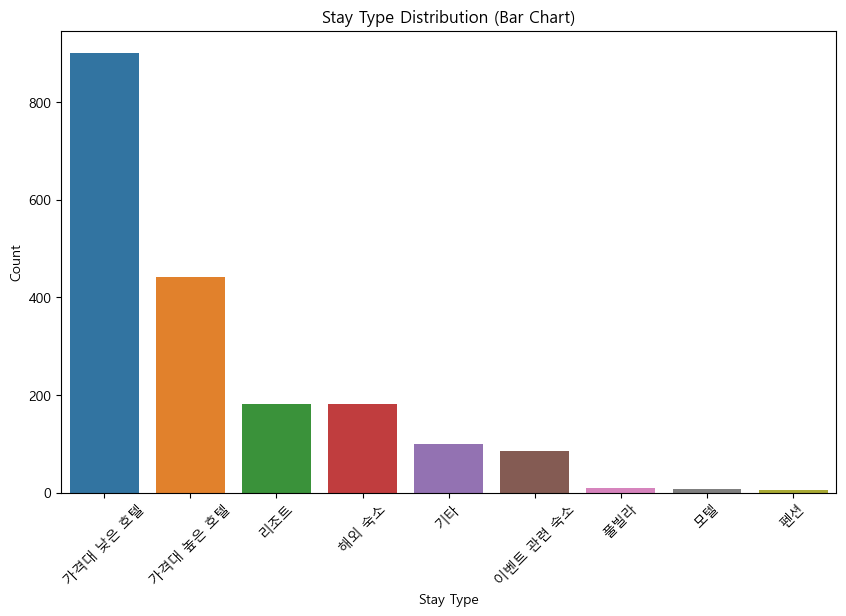

In [38]:
sub_category_counts = df['sub_category'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=sub_category_counts.index, y=sub_category_counts.values)
plt.title('Stay Type Distribution (Bar Chart)')
plt.xlabel('Stay Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


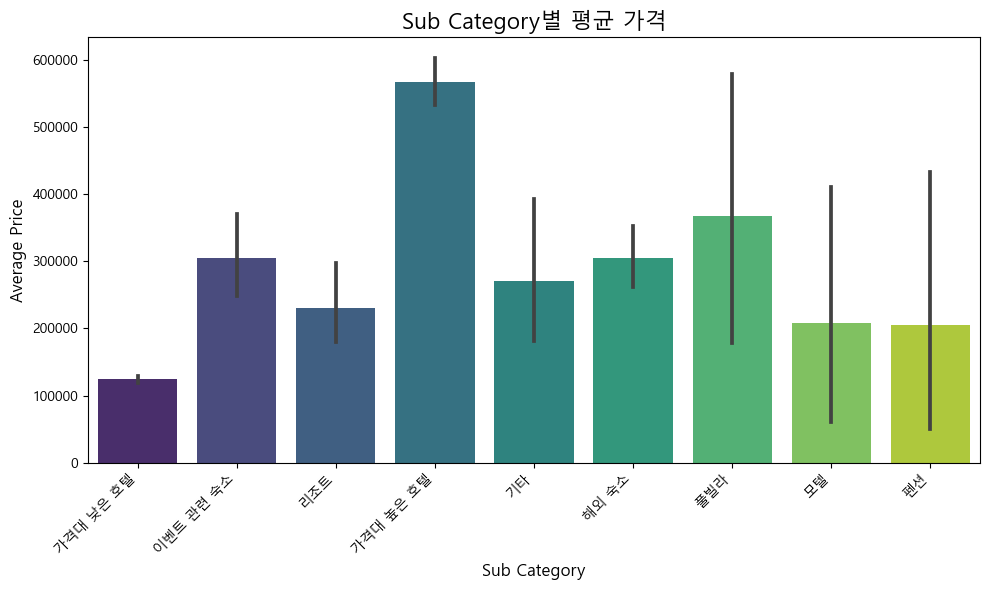

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(x='sub_category', y='price', data=df, palette='viridis')  # 막대 그래프 생성
plt.title('Sub Category별 평균 가격', fontsize=16)
plt.xlabel('Sub Category', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 

plt.show()

### 마감 기한

In [40]:
df['expiration_endate'] = pd.to_datetime(df['expiration_endate'], format='%Y-%m-%d', errors='coerce')
df['post_time'] = pd.to_datetime(df['post_time'], errors='coerce')

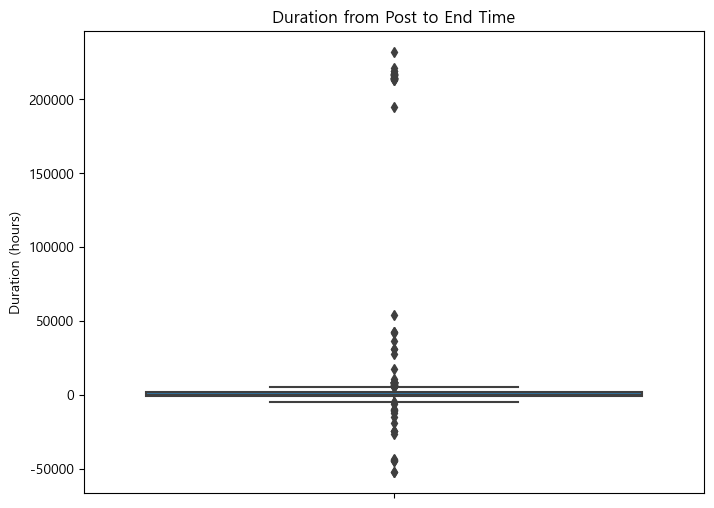

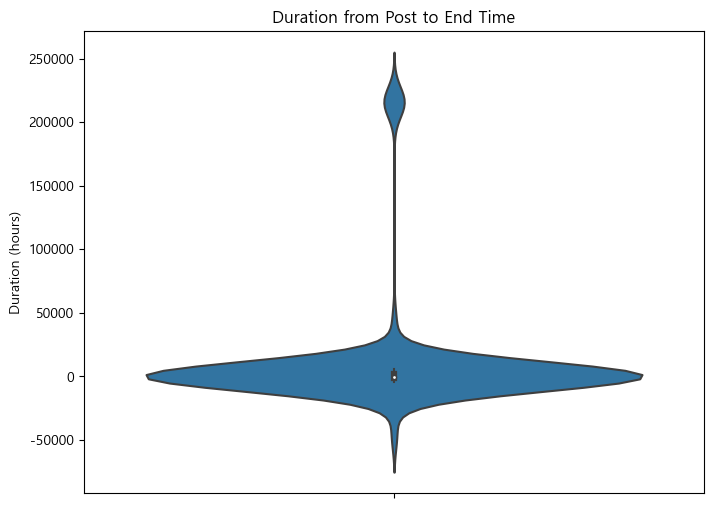

In [41]:
# 경과 시간 계산
df['duration'] = (df['expiration_endate'] - df['post_time']).dt.total_seconds() / 3600  # 시간 단위로 변환

# 박스 플롯
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['duration'])
plt.title('Duration from Post to End Time')
plt.ylabel('Duration (hours)')
plt.show()

# 바이올린 플롯
plt.figure(figsize=(8, 6))
sns.violinplot(y=df['duration'])
plt.title('Duration from Post to End Time')
plt.ylabel('Duration (hours)')
plt.show()


C:\Users\gmldu\AppData\Local\Temp\ipykernel_20052\205423488.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024['duration'] = (df_2024['expiration_endate'] - df_2024['post_time']).dt.total_seconds() / 86400  # 시간 단위로 변환


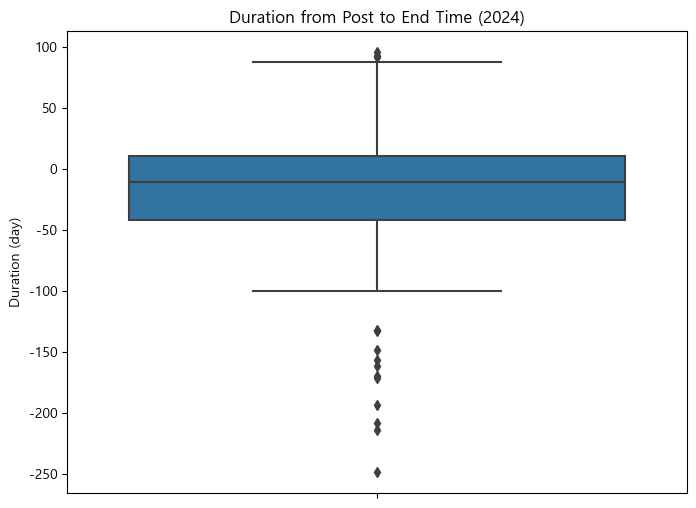

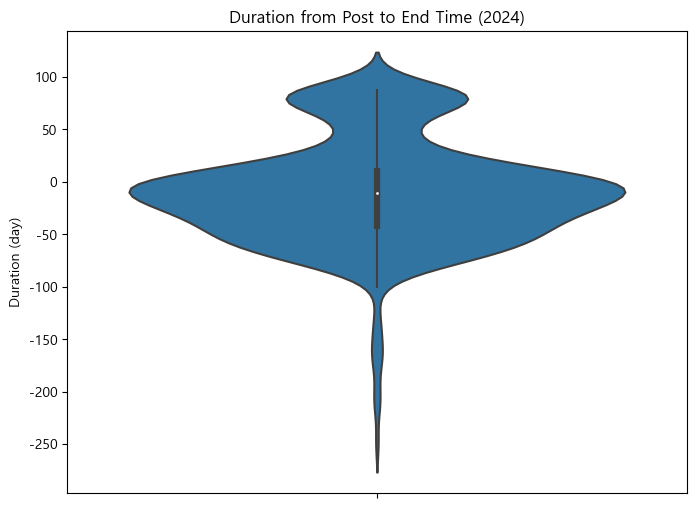

In [42]:
# 마감 시간이 2024년인 데이터 필터링
df_2024 = df[df['expiration_endate'].dt.year == 2024]

# 경과 시간 계산
df_2024['duration'] = (df_2024['expiration_endate'] - df_2024['post_time']).dt.total_seconds() / 86400  # 시간 단위로 변환

# 박스 플롯
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_2024['duration'])
plt.title('Duration from Post to End Time (2024)')
plt.ylabel('Duration (day)')
plt.show()

# 바이올린 플롯
plt.figure(figsize=(8, 6))
sns.violinplot(y=df_2024['duration'])
plt.title('Duration from Post to End Time (2024)')
plt.ylabel('Duration (day)')
plt.show()

### 시장 가격

In [43]:
df['market_price'].describe()

count    5.390000e+02
mean     4.232697e+05
std      1.044400e+06
min      0.000000e+00
25%      1.200000e+05
50%      2.400000e+05
75%      5.000000e+05
max      2.200000e+07
Name: market_price, dtype: float64

In [44]:
df[df['market_price']<=10000]['market_price']

15        34.0
122     9977.0
244        0.0
353       30.0
384        0.0
759       70.0
985      130.0
1476       0.0
1822     120.0
Name: market_price, dtype: float64

In [45]:
df.loc[df['market_price']<=10000,'market_price'] = np.nan

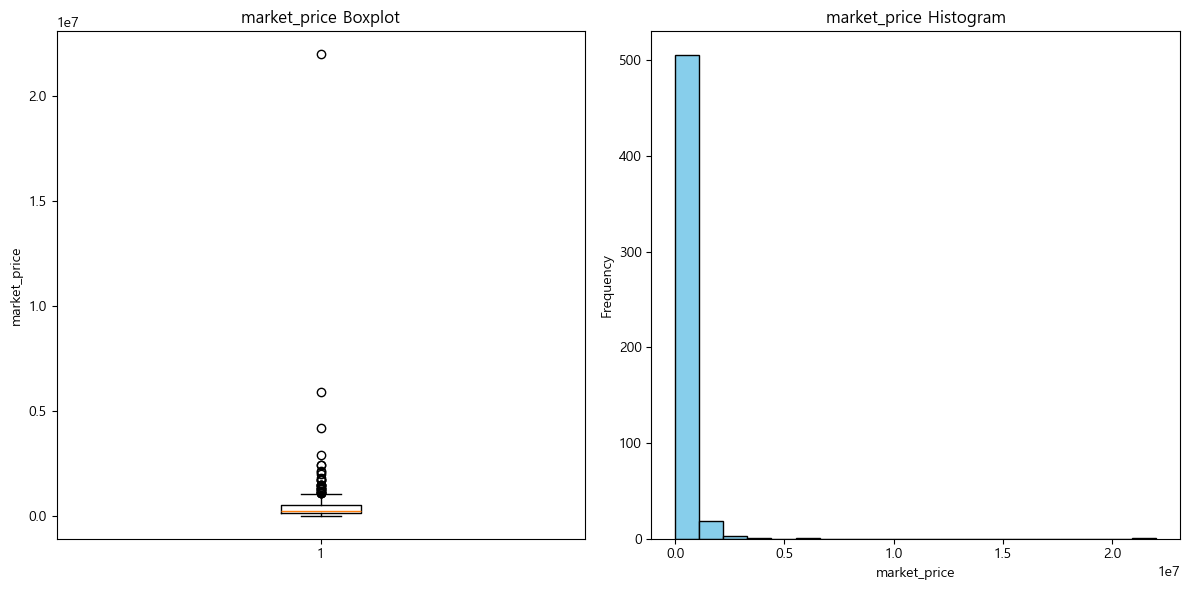

In [46]:
market_df = df[df['market_price'].notnull()]
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

axes[0].boxplot(market_df['market_price'])
axes[0].set_title('market_price Boxplot')
axes[0].set_ylabel('market_price')

axes[1].hist(market_df['market_price'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('market_price Histogram')
axes[1].set_xlabel('market_price')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

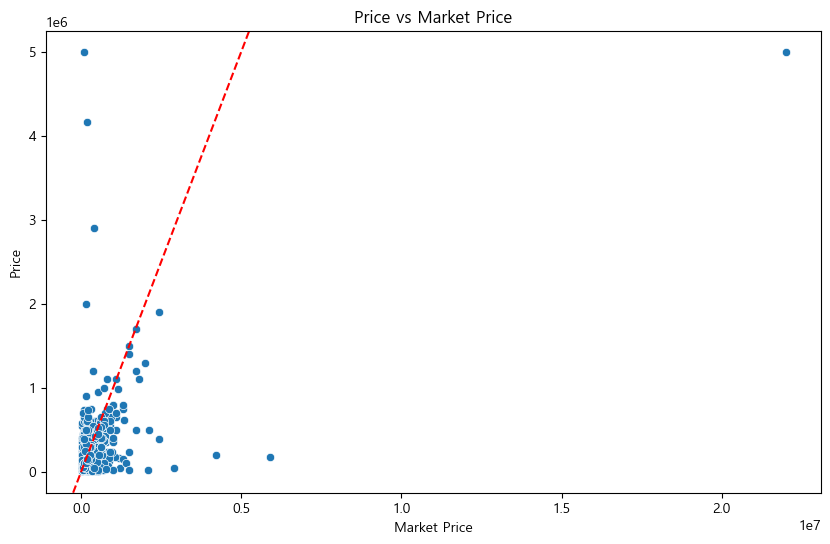

In [47]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='market_price', y='price')
plt.title('Price vs Market Price')
plt.xlabel('Market Price')
plt.ylabel('Price')
plt.axline((0, 0), slope=1, color='red', linestyle='--')
plt.show()

In [48]:
df.loc[df['market_price']==df['market_price'].max(),'market_price'] = np.nan

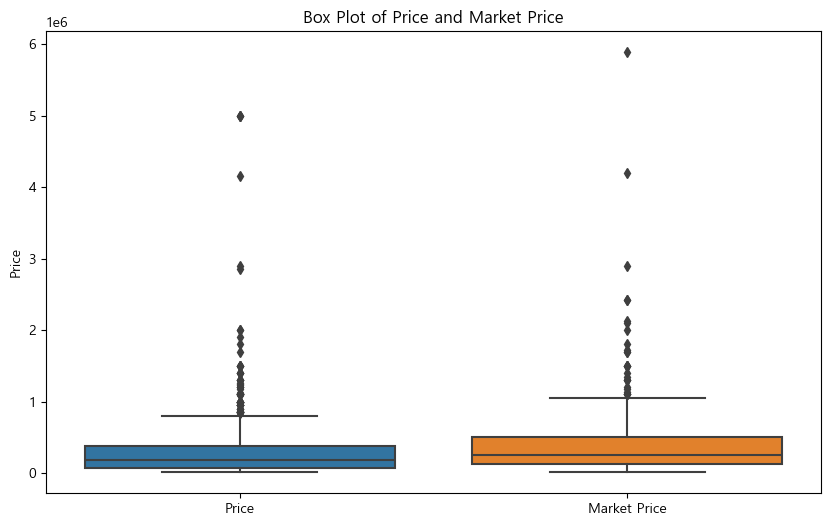

In [49]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['price', 'market_price']])
plt.title('Box Plot of Price and Market Price')
plt.ylabel('Price')
plt.xticks([0, 1], ['Price', 'Market Price'])
plt.show()

### 옵션

In [50]:
df[df['options'].notnull()]['options'][1895].split(',')

['조식', ' 레드와인 한병', ' 롯데월드 자유이용권', ' 클럽라운지 혜택', ' 락볼링장 3만원']

In [51]:
df['options_split'] = df['options'].apply(lambda x: [item.strip() for item in x.split(',')] if pd.notnull(x) else x)

In [52]:
from collections import Counter

all_options = [item for sublist in df['options_split'].dropna() for item in sublist]

option_counts = Counter(all_options)

# 빈도 확인
option_counts.most_common()

[('조식 포함', 151),
 ('조식', 81),
 ('수영장', 78),
 ('조식포함', 37),
 ('사우나', 34),
 ('오션뷰', 34),
 ('피트니스', 24),
 ('석식포함', 20),
 ('취사', 18),
 ('테마파크 빅3이용권 제공', 17),
 ('헬스장', 16),
 ('휘트니스 이용가능', 15),
 ('해피아워', 15),
 ('애프터눈티', 13),
 ('트윈', 12),
 ('조식2인', 9),
 ('바다뷰', 9),
 ('조식 불포함', 9),
 ('석식', 9),
 ('실시간 예약 가능', 9),
 ('스위트', 9),
 ('부분오션뷰', 9),
 ('클린', 9),
 ('실내수영장', 8),
 ('사우나 무료', 8),
 ('테라스', 8),
 ('패밀리', 8),
 ('가든', 8),
 ('렌탈샵', 8),
 ('침대', 8),
 ('온천', 7),
 ('조식 제공', 7),
 ('더블', 7),
 ('라운지 포함', 6),
 ('무료 와이파이', 6),
 ('섬모라 조식 2인', 6),
 ('싱글', 6),
 ('그랜드테이블 조식 부페권', 6),
 ('파셜오션뷰', 6),
 ('시티뷰', 5),
 ('오후 4시 체크아웃', 5),
 ('에어컨', 5),
 ('TV', 5),
 ('바다전망', 5),
 ('조식불포함', 5),
 ('키즈클럽', 5),
 ('냉장고', 5),
 ('조식뷔페', 5),
 ('바다', 5),
 ('파노라마', 5),
 ('자녀 조식 무료', 4),
 ('클럽라운지 2명 포함', 4),
 ('플레이랩', 4),
 ('티타임', 4),
 ('라세느 조식2인', 4),
 ('와인&과일커티시', 4),
 ('야외수영장', 4),
 ('레스토랑', 4),
 ('주차', 4),
 ("부산 농심호텔 '리스또란떼' 뷔페", 4),
 ('울산 호텔현대 바이 라한 ‘더 플레이트’ 뷔페', 4),
 ('워터파크 40% 할인권 제공', 4),
 ('컨벤션 더블', 4),
 ('라세느', 4),
 ('실버

c:\Users\gmldu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


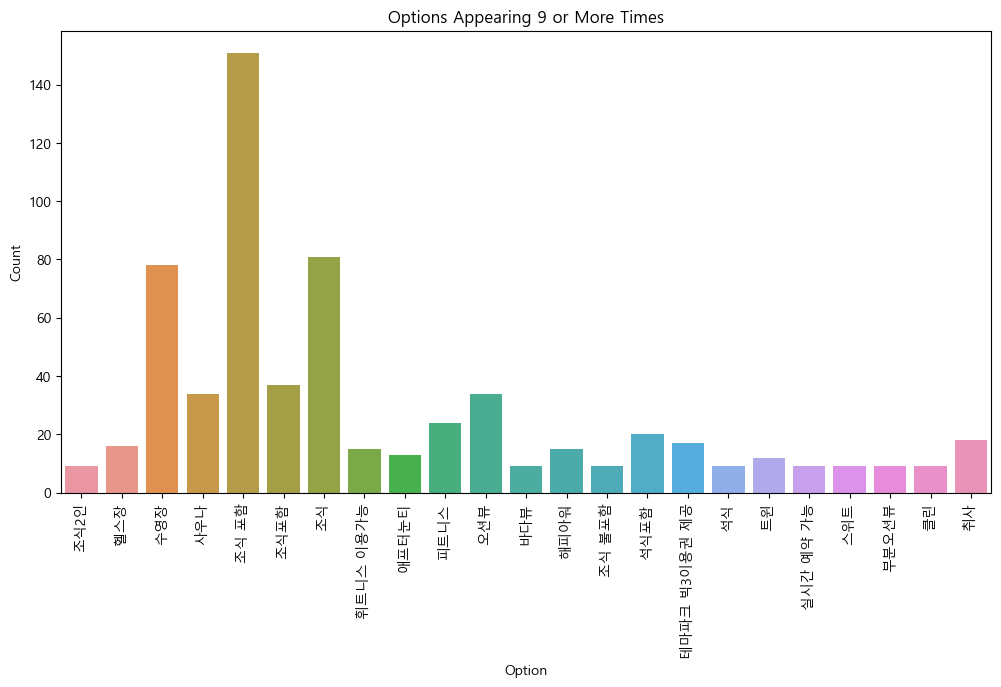

In [53]:

filtered_option_counts = {option: count for option, count in option_counts.items() if count >= 9}

options = list(filtered_option_counts.keys())
counts = list(filtered_option_counts.values())

plt.figure(figsize=(12, 6))
sns.barplot(x=options, y=counts)
plt.xticks(rotation=90) 
plt.title('Options Appearing 9 or More Times')
plt.xlabel('Option')
plt.ylabel('Count')
plt.show()

In [54]:
option_df = df[df['options'].notnull()]
option_df.reset_index(drop=True,inplace=True)
option_df['options_count'] = option_df['options_split'].apply(lambda x: len(x) if isinstance(x, list) else 0)

C:\Users\gmldu\AppData\Local\Temp\ipykernel_20052\3471261175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  option_df['options_count'] = option_df['options_split'].apply(lambda x: len(x) if isinstance(x, list) else 0)


In [55]:
# 이상치
option_df[option_df['options_count']>10]['options_split'][421]

['서울웨스틴조선',
 '노보텔앰배서더강남',
 '안다즈 강남',
 '콘래드호텔',
 '메이필드',
 '그랜드머큐어앰배서더호텔',
 '앰배서더 서울풀만',
 '그랜드 워커힐',
 '노보텔 앰배서더 서울 동대문 호텔&레지던스',
 '제주신화월드(서머셋콘도-10만원 추가금 발생/메리어트호텔)',
 '해비치호텔',
 '아덴힐리조트',
 '제주베이힐',
 '그랜드제주조선',
 '제주휘닉스리조트',
 '제주히든클리프',
 '위(WE)호텔 제주',
 '부산파라다이스',
 '부산웨스틴조선',
 '롯데부산',
 '해운대 티볼리(한화 리조트)',
 '홀리데이인알펜시아콘도',
 '인터컨티넨탈알펜시아호텔',
 '홀리데이인리조트',
 '하이원펠리스호텔',
 '설악켄싱턴스타',
 '켄싱턴호텔평창',
 '휘 닉스평창 호텔',
 '설악 쏘라노',
 '소노캄여수(주말 및 연휴불가)',
 '여수히든베이',
 '한화리조트 대천 파로스',
 '롯데부여리조트',
 '엘도라도',
 '광주홀리데이인',
 '거제삼성호텔',
 '반얀트리 방콕 (2박',
 '1박당 50$ 추가금 발생)']

In [56]:
option_df = option_df[option_df['options_count']<=10]

상관 관계:                options_count     price
options_count       1.000000  0.046019
price               0.046019  1.000000


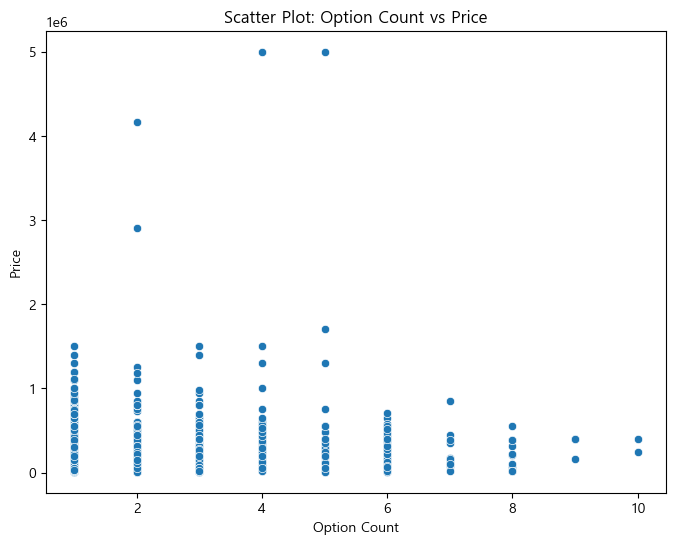

In [57]:
correlation = option_df[['options_count','price']].corr()
print(f"상관 관계: {correlation}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x='options_count', y='price', data=option_df)
plt.title('Scatter Plot: Option Count vs Price')
plt.xlabel('Option Count')
plt.ylabel('Price')
plt.show()

### 체크인,아웃 시간

In [58]:
df['check_in_time'].value_counts()

check_in_time
15:00               145
16:00                20
09:30                19
00:00                13
12:00                 7
14:00                 7
17:00                 6
10:00                 5
20:00                 5
18:00                 4
13:00                 4
체크인 시간 미기재            3
21:00                 2
09:00                 2
08:00                 1
03:00                 1
15:30                 1
04:00                 1
05:00                 1
Unknown               1
오전 00:00              1
2024-09-10            1
19:00                 1
2024-12-25T00:00      1
HH:MM                 1
월-금 00:00             1
22:00                 1
11:00                 1
23:00                 1
금요일부터 가능              1
오전                    1
월요일 00:00             1
체킨                    1
365,000               1
Name: count, dtype: int64

In [59]:
df['check_out_time'].value_counts()

check_out_time
11:00               103
12:00                67
18:00                19
16:00                12
14:00                12
00:00                12
13:00                 6
15:00                 3
21:00                 2
17:00                 2
10:00                 2
레이트체크아웃               2
체크아웃 시간 미기재           2
HH:MM                 1
2024-09-11            1
22:00                 1
넉넉                    1
Unknown               1
11:30                 1
주말 금요일 00:00          1
10:30                 1
23:00                 1
2024-12-30T00:00      1
~오후 2시                1
일요일까지 가능              1
오후 6시 30분             1
화요일 00:00             1
아웃입니다                 1
01:00                 1
레이트 체크아웃              1
오후 00:00              1
Name: count, dtype: int64

GPT 프롬프트 수정 필요

### 숙소 종류

In [60]:
df['stay_type'].value_counts()

stay_type
호텔     1581
리조트     189
기타      119
풀빌라       9
모텔        9
펜션        5
Name: count, dtype: int64

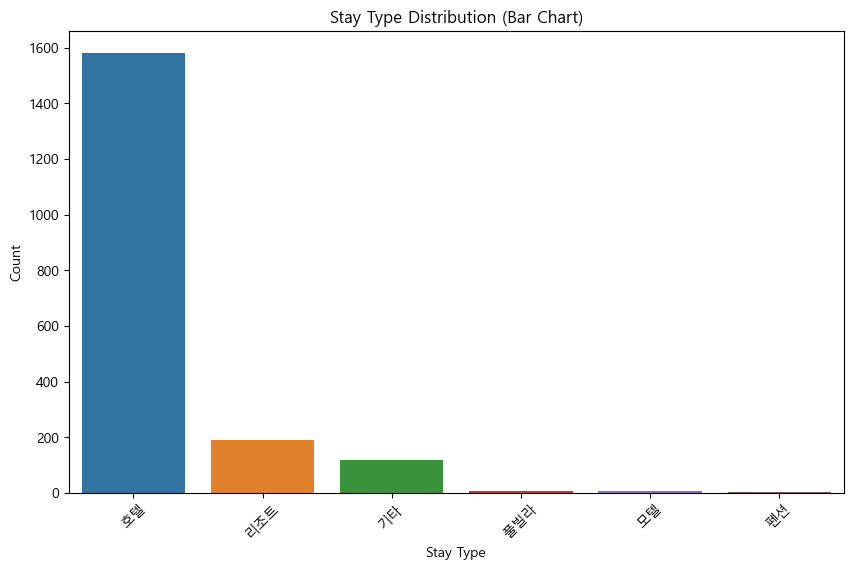

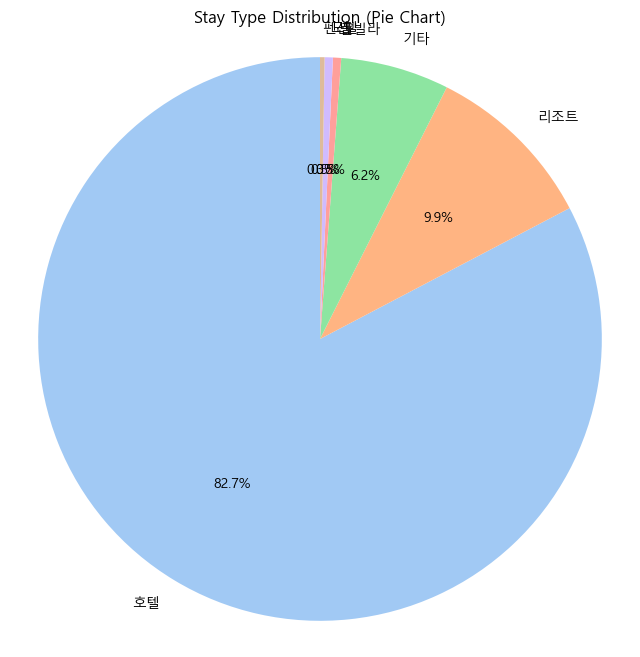

In [61]:

stay_type_counts = df['stay_type'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=stay_type_counts.index, y=stay_type_counts.values)
plt.title('Stay Type Distribution (Bar Chart)')
plt.xlabel('Stay Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(stay_type_counts.values, labels=stay_type_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Stay Type Distribution (Pie Chart)')
plt.axis('equal')
plt.show()

### 국내/외국

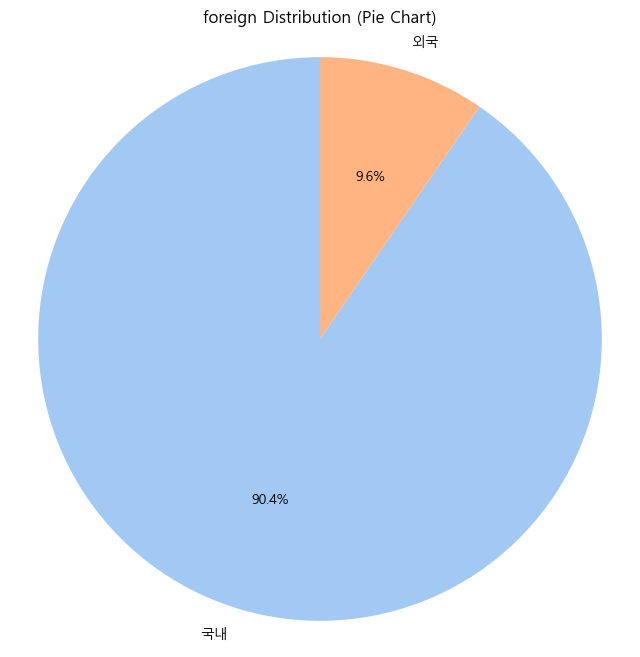

In [62]:
foreignn_counts = df['foreignn'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(foreignn_counts.values, labels=foreignn_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('foreign Distribution (Pie Chart)')
plt.axis('equal')
plt.show()

In [107]:
df['price'].mean()

270733.5